# Variation of phase and power with included morphology for 5.6GHz Bernard

In [1]:
from WIPL_python_analysis.SinglePolPlots import SinglePolPlots
from WIPL_python_analysis.DualPol import DualPol
from WIPL_python_analysis.DictToSinglePolResults import OutputDictToSinglePolResultsConverter as converter
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./')

In [2]:
def plot_corrected_rcs(df, title=None):
    phi = df['phi']
    corrected_rcs = df['Corrected_RCS']
    
    plt.figure(figsize=(8, 6))
    plt.plot(phi, corrected_rcs, label='Corrected RCS')
    plt.xlabel('Azimuth (degrees)')
    plt.ylabel('Corrected RCS (cm^2)')

    if title:
        plt.title(title)

    plt.legend()
    plt.show()

In [3]:
BASE_DRIVE_PATH = '/Users/sstk4353/Library/CloudStorage/GoogleDrive-thomas.matthews@ncas.ac.uk/My Drive/WIPL/Bernard_ellipsoid_comparison/'
BERNARD_PATH = 'Bernard/'
ELLIPSOID_PATH = 'Ellipsoid/'

In [32]:
scale = '1000'
morpho = 'body_wing'
wing_pos_list = ['U','M', 'D']
pol_list = ['H', 'V']
frequency_name = '560'

In [33]:
data_dict = {x : {y: None for y in wing_pos_list} for x in pol_list}
ellipsoid_data_dict = {x : None for x in pol_list}

In [34]:
for wing_pos in wing_pos_list:
    for pol in pol_list:

            path = BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/dict/wing_pos_analysis/Bernard_parameterised_{frequency_name}_{pol}_{wing_pos}_{scale}_{morpho}_p0_s0_dict.pkl'
            conv = converter.from_pickle(path)
            df = conv.generate_output_df()
            
            output_path = BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/csv/wing_pos_analysis/Bernard_parameterised_{frequency_name}_{pol}_{wing_pos}_{scale}_{morpho}_p0_s0_df.csv'
            df.to_csv(output_path)
            data_dict[pol][wing_pos] = df

In [35]:
df_bernard = data_dict['H']['U']

In [36]:
for pol in pol_list:
            path = BASE_DRIVE_PATH + ELLIPSOID_PATH + f'parameterised/dict/Ellipsoid_parameterised_{frequency_name}_{pol}_{scale}_p0_s0_dict.pkl'
            conv = converter.from_pickle(path)
            df = conv.generate_output_df()
            
            output_path = BASE_DRIVE_PATH + ELLIPSOID_PATH + f'parameterised/csv/Ellipsoid_parameterised_{frequency_name}_{pol}_{scale}_p0_s0__df.csv'
            df.to_csv(output_path)
            ellipsoid_data_dict[pol] = df

In [37]:
def get_horizontal_returned_phase(df):
    horizontal_field = df['Ephi'].astype(complex).to_numpy()
    phase = np.angle(horizontal_field) * 180 / np.pi
    return phase

def get_vertical_returned_phase(df):
    vertical_field = df['Etheta'].astype(complex).to_numpy()
    phase = np.angle(vertical_field) * 180 / np.pi
    return phase

def get_horizontal_returned_power(df):
    horizontal_field = df['Ephi'].astype(complex).to_numpy()
    power = np.abs(horizontal_field)**2
    return power

def get_vertical_returned_power(df):
    vertical_field = df['Etheta'].astype(complex).to_numpy()
    power = np.abs(vertical_field)**2
    return power

def get_linear_depol_ratio(df):
    horizontal_power = get_horizontal_returned_power(df)
    vertical_power = df['Etheta'].astype(complex).to_numpy()
    vertical_power = np.abs(vertical_power)**2
    depol_ratio = 10 * np.log10(vertical_power / horizontal_power)
    return depol_ratio

In [38]:
vars_list = ['HH_power', 'VV_power', 'Zdr', 'LDR', 'HH_phase', 'VV_phase', 'PhiDP']

In [39]:
results_dict = {y : {z : None for z in vars_list} for y in wing_pos_list}


for wing_pos in wing_pos_list: 
    results_dict[wing_pos]['HH_power'] = get_horizontal_returned_power(data_dict['H'][wing_pos])
    results_dict[wing_pos]['VV_power'] = get_vertical_returned_power(data_dict['V'][wing_pos])
    results_dict[wing_pos]['HH_phase'] = get_horizontal_returned_phase(data_dict['H'][wing_pos])
    results_dict[wing_pos]['VV_phase'] = get_vertical_returned_phase(data_dict['V'][wing_pos])
    results_dict[wing_pos]['LDR'] = get_linear_depol_ratio(data_dict['H'][wing_pos])

    dp = DualPol(data_dict['H'][wing_pos], data_dict['V'][wing_pos], read_from_df=True)
    dp._calculate_differential_reflectivity()
    dp._calculate_differential_phase()

    results_dict[wing_pos]['Zdr'] = dp.differential_reflectivity
    results_dict[wing_pos]['PhiDP'] = dp.differential_phase


In [56]:
ellipsoid_results_dict = {y : None for y in vars_list}

ellipsoid_results_dict['HH_power'] = get_horizontal_returned_power(ellipsoid_data_dict['H'])
ellipsoid_results_dict['VV_power'] = get_vertical_returned_power(ellipsoid_data_dict['V'])
ellipsoid_results_dict['HH_phase'] = get_horizontal_returned_phase(ellipsoid_data_dict['H'])
ellipsoid_results_dict['VV_phase'] = get_vertical_returned_phase(ellipsoid_data_dict['V'])
ellipsoid_results_dict['LDR'] = get_linear_depol_ratio(ellipsoid_data_dict['H'])
dp = DualPol(ellipsoid_data_dict['H'], ellipsoid_data_dict['V'], read_from_df=True)
dp._calculate_differential_reflectivity()
dp._calculate_differential_phase()
ellipsoid_results_dict['Zdr'] = dp.differential_reflectivity
ellipsoid_results_dict['PhiDP'] = dp.differential_phase

# Power with wing pos

Text(0.5, 1.0, 'Variation of HH scattered power with wing position at 5.6GHz')

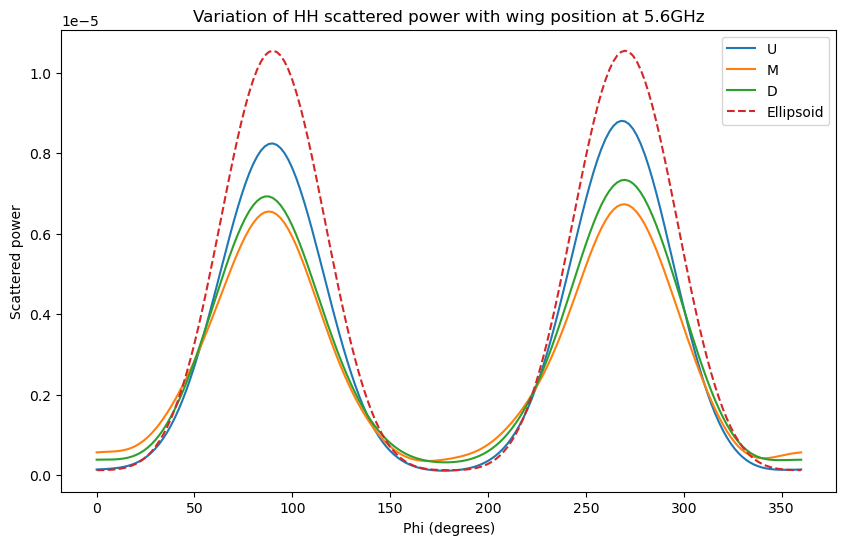

In [57]:
pol = 'H'

for wing_pos in wing_pos_list:

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]

    plt.plot(df_bernard['phi'], results_dict[wing_pos]['HH_power'], label=f'{wing_pos}', linestyle = '-')
plt.plot(df_bernard['phi'], ellipsoid_results_dict['HH_power'], label='Ellipsoid', linestyle = '--')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Scattered power')
plt.title(f'Variation of HH scattered power with wing position at 5.6GHz')

Text(0.5, 1.0, 'Variation of VV scattered power with wing position at 5.6GHz')

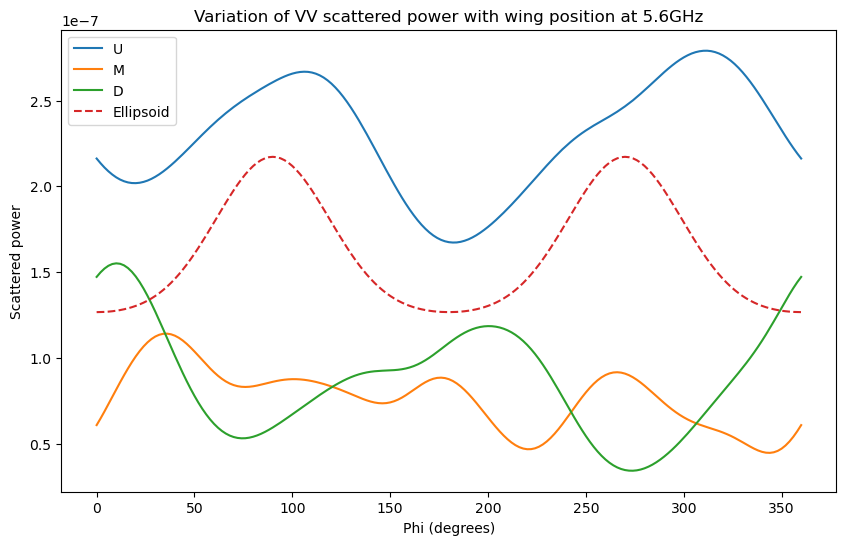

In [58]:
pol = 'H'

for wing_pos in wing_pos_list:

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]

    plt.plot(df_bernard['phi'], results_dict[wing_pos]['VV_power'], label=f'{wing_pos}', linestyle = '-')
plt.plot(df_bernard['phi'], ellipsoid_results_dict['VV_power'], label='Ellipsoid', linestyle = '--')


fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Scattered power')
plt.title(f'Variation of VV scattered power with wing position at 5.6GHz')

Text(0.5, 1.0, 'Variation of Zdr with wing position at 5.6GHz')

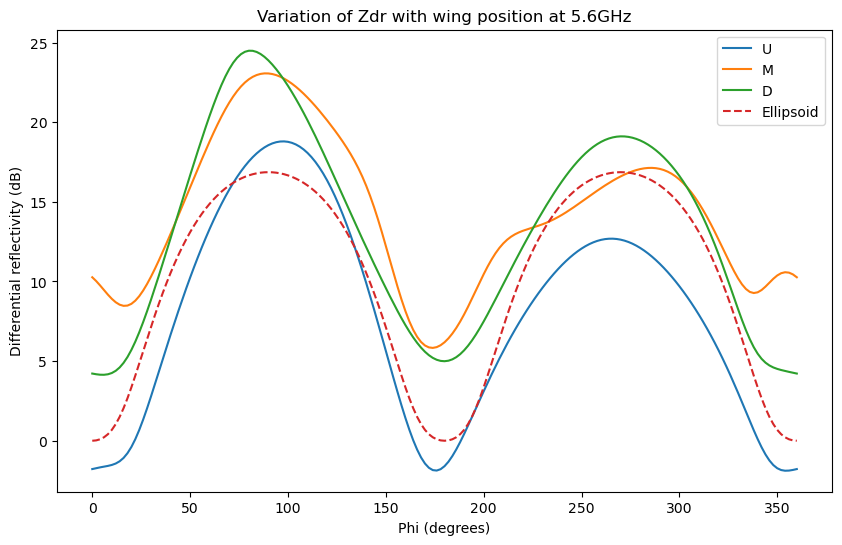

In [63]:
pol = 'H'

for wing_pos in wing_pos_list:

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]

    plt.plot(df_bernard['phi'], results_dict[wing_pos]['Zdr'], label=f'{wing_pos}', linestyle = '-')
plt.plot(df_bernard['phi'], ellipsoid_results_dict['Zdr'], label='Ellipsoid', linestyle = '--')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Differential reflectivity (dB)')
plt.title(f'Variation of Zdr with wing position at 5.6GHz')

Text(0.5, 1.0, 'Variation of LDR with wing position at 5.6GHz')

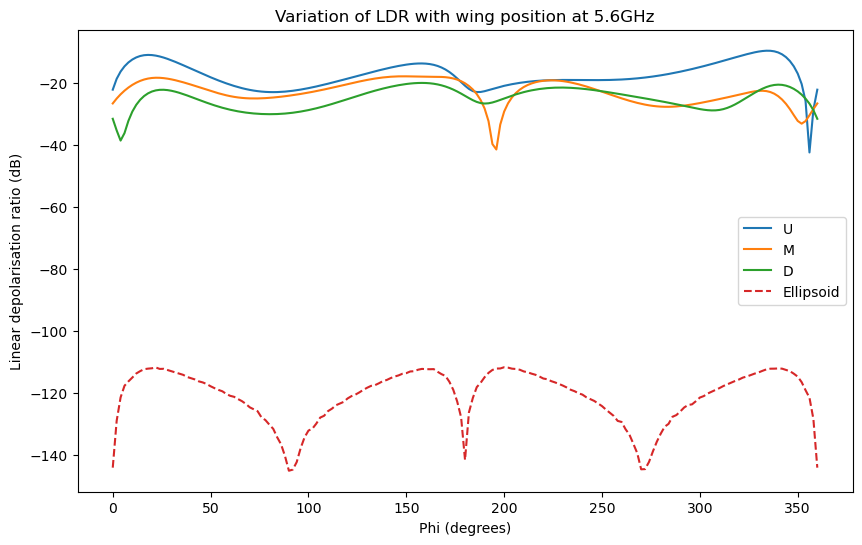

In [62]:
pol = 'H'

for wing_pos in wing_pos_list:

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]

    plt.plot(df_bernard['phi'], results_dict[wing_pos]['LDR'], label=f'{wing_pos}', linestyle = '-')
plt.plot(df_bernard['phi'], ellipsoid_results_dict['LDR'], label='Ellipsoid', linestyle = '--')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Linear depolarisation ratio (dB)')
plt.title(f'Variation of LDR with wing position at 5.6GHz')

# Phase with wing position

Text(0.5, 1.0, 'Variation of HH phase with wing position at 5.6GHz')

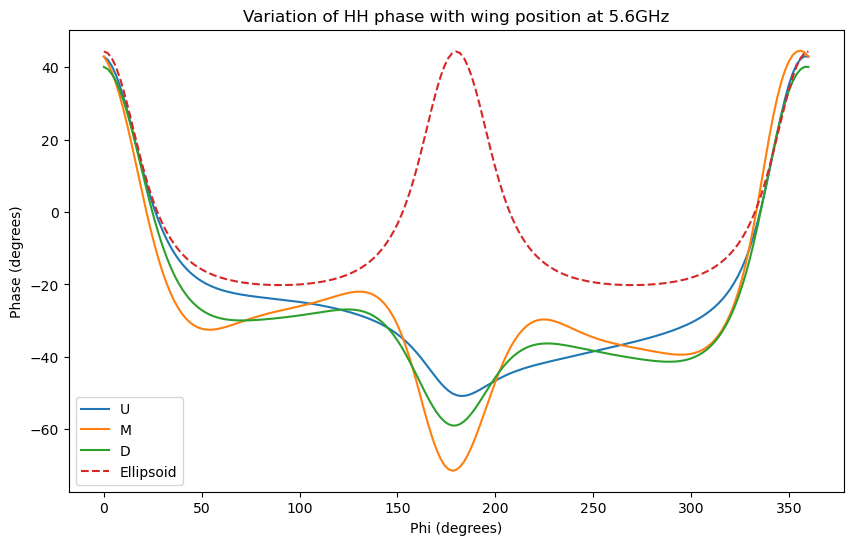

In [64]:
pol = 'H'

for wing_pos in wing_pos_list:

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]

    plt.plot(df_bernard['phi'], results_dict[wing_pos]['HH_phase'], label=f'{wing_pos}', linestyle = '-')
plt.plot(df_bernard['phi'], ellipsoid_results_dict['HH_phase'], label='Ellipsoid', linestyle = '--')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Phase (degrees)')
plt.title(f'Variation of HH phase with wing position at 5.6GHz')

Text(0.5, 1.0, 'Variation of VV phase with wing position at 5.6GHz')

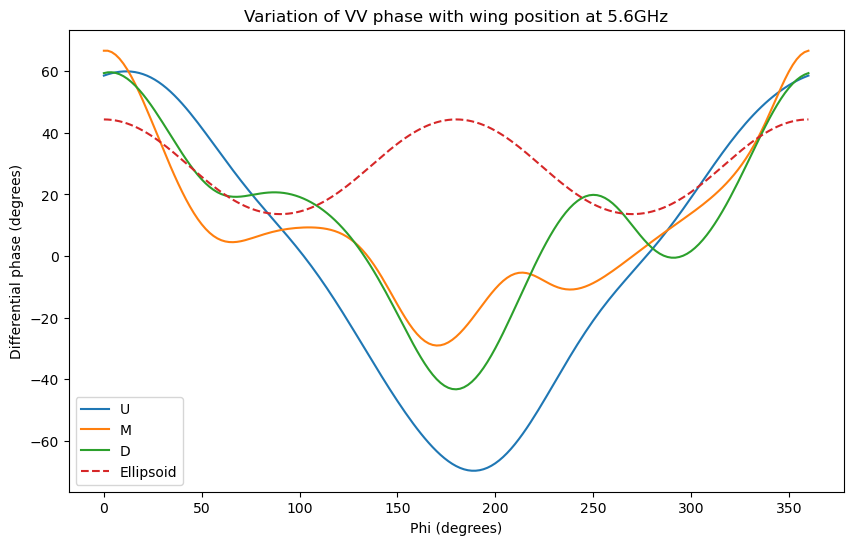

In [65]:
pol = 'H'

for wing_pos in wing_pos_list:

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]

    plt.plot(df_bernard['phi'], results_dict[wing_pos]['VV_phase'], label=f'{wing_pos}', linestyle = '-')
plt.plot(df_bernard['phi'], ellipsoid_results_dict['VV_phase'], label='Ellipsoid', linestyle = '--')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Differential phase (degrees)')
plt.title(f'Variation of VV phase with wing position at 5.6GHz')

Text(0.5, 1.0, 'Variation of PhiDP with wing position at 5.6GHz')

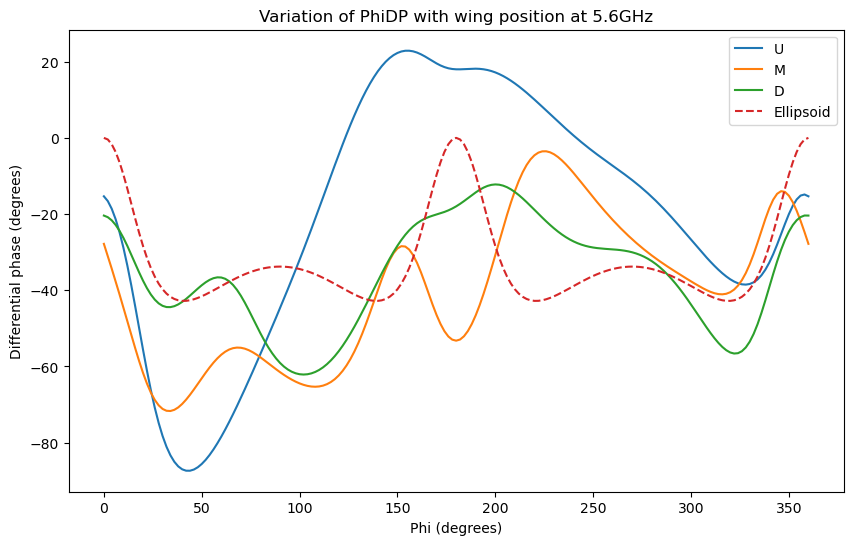

In [66]:
for wing_pos in wing_pos_list:

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]

    plt.plot(df_bernard['phi'], results_dict[wing_pos]['PhiDP'], label=f'{wing_pos}', linestyle = '-')
plt.plot(df_bernard['phi'], ellipsoid_results_dict['PhiDP'], label='Ellipsoid', linestyle = '--')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Differential phase (degrees)')
plt.title(f'Variation of PhiDP with wing position at 5.6GHz')